# Данные

Получить из имеющихся 3D координат представление белка в виде графа. Базовая идея: матрица смежности + матрица признаков

Важно: в данных с CASP нет информации о ковалентных связях, нужно их получить

Some additional ideas:
* добавить веса на ребрах (например вместо {0,1} ставить значения расстояний между атомами)
* представление графа: Диаграмма Вороного

Данные взяты с сайта CASP 
>[CASP12](http://predictioncenter.org/casp12/index.cgi) $\to$ RESULTS $\to$ parsable data
* Реальные модели: targets/casp12.targets_T0.releaseDec022016.tgz
* Сгенерированные модели: server_predictions/T*.stage2.3D.srv.tar.gz

## Retrieve CAD-score

* Train dataset: сгенерированные модели белков + реальные соответствующие смоделированным белки. На основе их считаем CAD-score. X_train = сгенерированные модели белков, y_train = CAD-scores
* Test: CASP competition, выдается n смоделированных белков, предполагается, что они якобы из норм распределения, чтобы z-score вычислить. орги каждой модели присваивают Z-score того, насколько хороша модель(замена нашему CAD-score). Ранжируют модели по z-скору. участникам дается этот набор моделей, мы ранжируем/выбираем лучшую и орги оценивают по своему z-скору, насколько хорошую выбрали

Получим cad-scores для всех имеющихся моделей

Использовалась реализация подсчета cad-score из https://github.com/kliment-olechnovic/voronota

In [1]:
!bash 0_do_cadscore_script.bash

bash: 0_do_cadscore_script.bash: No such file or directory


Для каждого таргета записали в файл результаты cad-scores всех моделей в виде:

{target file path} {model file path} {query code} {number of residues} {global score} {target total area} {corresponding model total area}

global score и есть значение cad-score

## Загрузка и анализ данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import math
import time, datetime
import random
#import scipy.optimize as optim
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.style.use('seaborn')

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [3]:
!pip install biopandas

     |████████████████████████████████| 266kB 2.8MB/s 


In [2]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()

Пока используем данные с CASP12

In [3]:
# for colab
#models_path = '/content/drive/My Drive/CASP/CASP12/'
#target_path = '/content/drive/My Drive/CASP/targets_T0_/'
models_path = '../../data/CASP12/'
target_path = '../../data/targets_T0_/'

In [4]:
targets = os.listdir(models_path)
target_names = sorted([s.replace('.pdb', '') for s in targets])[1:] # [1:] т.к. считывает системный файл .DS_store
print(target_names)

['T0859', 'T0860', 'T0861', 'T0862', 'T0863', 'T0864', 'T0865', 'T0866', 'T0868', 'T0869', 'T0870', 'T0871', 'T0879', 'T0886', 'T0889', 'T0891', 'T0892', 'T0893', 'T0896', 'T0897', 'T0898', 'T0900', 'T0902', 'T0903', 'T0904', 'T0911', 'T0912', 'T0918', 'T0920', 'T0921', 'T0922', 'T0928', 'T0941', 'T0942', 'T0943', 'T0944', 'T0945']


In [5]:
example = ppdb.read_pdb(target_path + targets[14] + '.pdb')

data_df = ppdb.df['ATOM']
#print(data_df.dtypes)
data_df.head()

record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  GLU           
1        ATOM            2                CA                  GLU           
2        ATOM            3                 C                  GLU           
3        ATOM            4                 O                  GLU           
4        ATOM            5                CB                  GLU           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0                        5            ...  47.050   22.333   32.472   
1                        5            ...  45.974   22.446   31.447   
2                        5            ...  44.642   22.769   32.134   
3                        5            ...  44.161   23.893   32.033   
4                        5            ...  45.884   21.162   30.619   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        1.0     39.28                                  N    NaN         6  
1        1.0     39.64                                  C    NaN         7  
2        1.0     29.37                                  C    NaN         8  
3        1.0     28.14                                  O    NaN         9  
4        1.0     46.61                                  C    NaN        10  

[5 rows x 21 columns]

In [6]:
residues = data_df.loc[:, ['residue_name']].values.tolist()
residue_names = set([i[0] for i in residues])
print(residue_names)

{'THR', 'ASP', 'PHE', 'GLU', 'TYR', 'HIS', 'ALA', 'GLN', 'PRO', 'SER', 'LEU', 'LYS', 'GLY', 'ARG', 'CYS', 'ILE', 'VAL', 'TRP', 'MET', 'ASN'}


[О типах аминокислот](https://www.sigmaaldrich.com/life-science/metabolomics/learning-center/amino-acid-reference-chart.html)

Дополнительно для вникания в данные http://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/formuleAA/#MLformula
<img src='https://i.imgur.com/g0Ydb2O.png' alt='aminos' width="600"/>



In [7]:
atoms = data_df.loc[:, ['atom_name']].values.tolist()
atom_names = set([i[0] for i in atoms])
print(atom_names)

{'OD2', 'OE1', 'CG2', 'CB', 'NE', 'NZ', 'CH2', 'NE1', 'SD', 'CE3', 'CG', 'O', 'OE2', 'CZ', 'NH1', 'CD1', 'CA', 'OD1', 'OG1', 'ND2', 'CE', 'ND1', 'CD', 'CD2', 'OH', 'CG1', 'CZ3', 'CZ2', 'N', 'CE2', 'C', 'CE1', 'NE2', 'NH2', 'OG', 'SG'}


In [8]:
elements = data_df.loc[:, ['element_symbol']].values.tolist()
elements_names = set([i[0] for i in elements])
print(elements_names)

{'C', 'S', 'N', 'O'}


## Матрица смежности

In [9]:
test_file = models_path + target_names[2] 
models_for_test = sorted(os.listdir(test_file))
print(models_for_test)

['ACOMPMOD_TS1', 'ACOMPMOD_TS2', 'ACOMPMOD_TS3', 'ACOMPMOD_TS4', 'ACOMPMOD_TS5', 'Atome2_CBS_TS1', 'Atome2_CBS_TS2', 'Atome2_CBS_TS4', 'Atome2_CBS_TS4.pdb', 'Atome2_CBS_TS5', 'BAKER-ROSETTASERVER_TS1', 'BAKER-ROSETTASERVER_TS2', 'BAKER-ROSETTASERVER_TS3', 'BAKER-ROSETTASERVER_TS4', 'BAKER-ROSETTASERVER_TS5', 'BhageerathH-Plus_TS1', 'BhageerathH-Plus_TS2', 'BhageerathH-Plus_TS3', 'BhageerathH-Plus_TS4', 'BhageerathH-Plus_TS5', 'Distill_TS1', 'Distill_TS2', 'Distill_TS3', 'Distill_TS4', 'Distill_TS5', 'FALCON_TOPOX_TS1', 'FALCON_TOPOX_TS2', 'FALCON_TOPOX_TS3', 'FALCON_TOPOX_TS4', 'FALCON_TOPOX_TS5', 'FALCON_TOPO_TS1', 'FALCON_TOPO_TS2', 'FALCON_TOPO_TS3', 'FALCON_TOPO_TS4', 'FALCON_TOPO_TS5', 'FFAS-3D_TS1', 'FFAS03_TS1', 'FLOUDAS_SERVER_TS1', 'FLOUDAS_SERVER_TS2', 'FLOUDAS_SERVER_TS3', 'FLOUDAS_SERVER_TS4', 'FLOUDAS_SERVER_TS5', 'GOAL_COMPLEX_TS1', 'GOAL_COMPLEX_TS2', 'GOAL_COMPLEX_TS3', 'GOAL_COMPLEX_TS4', 'GOAL_COMPLEX_TS5', 'GOAL_TS1', 'GOAL_TS2', 'GOAL_TS3', 'GOAL_TS4', 'GOAL_TS5', '

In [10]:
ttt = ppdb.read_pdb(models_path + target_names[2] + '/' + models_for_test[2])
print(target_names[2], models_for_test[2])
test_model = ppdb.df['ATOM']
#print(data_df.dtypes)
test_model.head()

T0861 ACOMPMOD_TS3


record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
0        ATOM            1                 N                  MET           
1        ATOM            2                CA                  MET           
2        ATOM            3                CB                  MET           
3        ATOM            4                CG                  MET           
4        ATOM            5                SD                  MET           

  chain_id  residue_number insertion  ... x_coord  y_coord  z_coord  \
0                        1            ...  66.699   22.996   39.453   
1                        1            ...  66.208   22.239   40.626   
2                        1            ...  64.684   22.050   40.545   
3                        1            ...  63.892   23.360   40.586   
4                        1            ...  63.975   24.260   42.163   

   occupancy  b_factor  blank_4 segment_id element_symbol charge  line_idx  
0        1.0     43.15                                       NaN         4  
1        1.0     43.15                                       NaN         5  
2        1.0     43.15                                       NaN         6  
3        1.0     43.15                                       NaN         7  
4        1.0     43.15                                       NaN         8  

[5 rows x 21 columns]

In [11]:
atoms = test_model.loc[:, ['atom_name']].values.tolist()
atom_names = set([i[0] for i in atoms])
print(atom_names)

{'OD2', 'OE1', 'CG2', 'CB', 'NZ', 'NE', 'CH2', 'NE1', 'SD', 'CE3', 'CG', 'O', 'OE2', 'CZ', 'NH1', 'CD1', 'OXT', 'CA', 'CE', 'OD1', 'ND2', 'OG1', 'ND1', 'CD', 'CD2', 'OH', 'CG1', 'CZ3', 'CZ2', 'N', 'CE2', 'C', 'CE1', 'NE2', 'NH2', 'OG', 'SG'}


In [12]:
kMinDistanceBetweenAtoms = 0.01

# элементы периодической системы и соответствующие им радиусы
periodic_table = {
  'H': 1.2, 'He': 1.4, 'Li': 1.82, 'Be': 2.0,
  'B': 2.0, 'C': 1.7, 'N': 1.55, 'O': 1.52,
  'F': 1.47, 'Ne': 1.54, 'Na': 2.27, 'Mg': 1.73,
  'Al': 2.0, 'Si': 2.1, 'P': 1.9, 'S': 1.8,
  'Cl': 1.75, 'Ar': 1.88, 'K': 2.75, 'Ca': 1.2,
  'Sc': 2.0, 'Ti': 2.0, 'V': 2.0, 'Cr': 2.0,
  'Mn': 2.0, 'Fe': 2.0, 'Co': 2.0, 'Ni': 1.63,
  'Cu': 1.4, 'Zn': 1.39, 'Ga': 1.07, 'Ge': 2.0,
  'Aa': 1.85, 'Se': 1.9, 'Br': 1.85, 'Kr': 2.02,
  'Rb': 2.0, 'Sr': 2.0, 'Y': 2.0, 'Zr': 2.0,
  'Nb': 2.0, 'Mo': 2.0, 'Tc': 2.0, 'Ru': 2.0,
  'Rh': 2.0, 'Pd': 1.63, 'Ag': 1.72, 'Cd': 1.58,
  'In': 1.93, 'Sn': 2.17, 'Sb': 2.0, 'Te': 2.06,
  'I': 1.98, 'Xe': 2.16, 'Cs': 2.0, 'Ba': 2.0,
  'La': 2.0, 'Ce': 2.0, 'Pr': 2.0, 'Nd': 2.0,
  'Pm': 2.0, 'Sm': 2.0, 'Eu': 2.0, 'Gd': 2.0,
  'Tb': 2.0, 'Dy': 2.0, 'Ho': 2.0, 'Er': 2.0,
  'Tm': 2.0, 'Yb': 2.0, 'Lu': 2.0, 'Hf': 2.0,
  'Ta': 2.0, 'W': 2.0, 'Re': 2.0, 'Os': 2.0,
  'Ir': 2.0, 'Pt': 1.72, 'Au': 1.66, 'Hg': 1.55,
  'Tl': 1.96, 'Pb': 2.02, 'Bi': 2.0, 'Po': 2.0,
  'At': 2.0, 'Rn': 2.0, 'Fr': 2.0, 'Ra': 2.0,
  'Ac': 2.0, 'Th': 2.0, 'Pa': 2.0, 'U': 1.86,
  'Np': 2.0, 'Pu': 2.0, 'Am': 2.0, 'Cm': 2.0,
  'Bk': 2.0, 'Cf': 2.0, 'Es': 2.0, 'Fm': 2.0,
  'Md': 2.0, 'No': 2.0, 'Lr': 2.0, 'Rf': 2.0,
  'Db': 2.0, 'Sg': 2.0, 'Bh': 2.0, 'Hs': 2.0,
  'Mt': 2.0, 'Ds': 2.0, 'Rg': 2.0
}

# получает радиус элемента
def getElementRadius(atom):
    '''
    если поле 'element_symbol' не пусто, выведем радиус, 
    соответствующий элементу в periodic_table,
    иначе будет выводить просто максимальный радиус из periodic_table
    '''
    if atom['element_symbol'] != '':
        return periodic_table[atom['element_symbol']]
    else:
        return 2.0
    

# расстояние между атомами
def getDistance(atom1, atom2):
    x1, y1, z1 = atom1['x_coord'], atom1['y_coord'], atom1['z_coord']
    x2, y2, z2 = atom2['x_coord'], atom2['y_coord'], atom2['z_coord']
    
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    
    
# проверяет, есть ли соединение между атомами
def HaveCovalentBond(atom1, atom2):

    # не соединяем атомы, которые находятся далеко в последовательности
    if (abs(atom1['residue_number'] - atom2['residue_number']) > 1):
        return False
    
    distance = getDistance(atom1, atom2)

    # не соединяем водороды
    # если водород, то element_symbol H, а значит первый символ atom_name тоже H
    # не проверяем element_symbol, т.к. столбца может не быть в данных
    if ('H' in atom1['atom_name'][0] and 'H' in atom2['atom_name'][0]):
        return False

    if (('H' in atom1['atom_name'][0] or 'H' in atom2['atom_name'][0]) and distance >= 1.21):
        return False

    # не создаем SS-связи
    if ('SG' in atom1['atom_name'] and 'SG' in atom2['atom_name']):
        return False

    distanceMax = ((getElementRadius(atom1) + getElementRadius(atom2)) * 0.6) ** 2

    return distance <= distanceMax and distance > kMinDistanceBetweenAtoms

def AdjacencyMatrix(target_name, model_name):
    
    pdb_file_path = models_path + target_name + '/' + model_name
    temp = ppdb.read_pdb(pdb_file_path)
    protein = ppdb.df['ATOM']
    
    if not os.path.exists(models_path + target_name + '/adjacency'):
        os.mkdir(models_path + target_name + '/adjacency')
        
    f = open(models_path + target_name + '/adjacency/' + model_name + '_adj.txt', "w")
    
    for i in range(protein.shape[0]):
        f.write('atom' + str(i))
        for j in range(protein.shape[0]):
            # т.к. матрица сильно разреженная, эффективнее записывать только 1
            if i != j and HaveCovalentBond(protein.loc[i], protein.loc[j]):
                #distance = getDistance(protein.loc[i], protein.loc[j])
                f.write(' ' + str(j))
                # возможно стоит записывать еще прочие признаки, как residue_number, distance, atom_name, residue_name
        f.write('\n')
    f.close()

In [0]:
targets2 = sorted(target_names)[1:5]
for i, target_name in enumerate(targets2):
    print('Target [{}/{}]\n{} started at {}'.format(i+1, len(targets2), 
                                                    target_name, datetime.datetime.now().time()))
    models = sorted(os.listdir(models_path + target_name))
    for model in tqdm(random.sample((models), 25)):
        AdjacencyMatrix(target_name, model)

Target [1/4]
T0860 started at 08:11:27.271152



Target [2/4]
T0861 started at 11:35:23.925630


In [15]:
targets5 = sorted(target_names)[7:8]
for i, target_name in enumerate(targets5):
    print('Target [{}/{}]\n{} started at {}'.format(i+1, len(targets5), 
                                                    target_name, datetime.datetime.now().time()))
    models = sorted(os.listdir(models_path + target_name))
    for model in tqdm(random.sample((models), 25)):
        #print(model)
        AdjacencyMatrix(target_name, model)

Target [1/1]
T0866 started at 19:33:27.917192


Итог: сделаны матрицы смежности для
* T0859 – 104 шт
* T0860 – 26 шт
* T0861 – 10 шт
* T0862 – 25 шт
* T0863 – 1 шт
* T0864 – 25 шт
* T0865 – 5 шт
* T0866 – 25 шт

**Суммарно: 221 шт**

In [ ]:
AdjacencyMatrix(target_name, model)

## Визуализация

https://pygsp.readthedocs.io/en/stable/reference/graphs.html

In [14]:
from pygsp import graphs, filters, plotting

In [13]:
adj_path = '../../data/CASP12/' + target_names[0]+ '/adjacency/'
adj_for_test = sorted(os.listdir(adj_path))[1:]

filepath = adj_path + adj_for_test[4]
print(filepath)

../../data/CASP12/T0859/adjacency/BAKER-ROSETTASERVER_TS2_adj.txt


In [14]:
with open(filepath) as fp:
    ttt = ppdb.read_pdb('../../data/CASP12/' + target_names[0] + '/'+ adj_for_test[4][:-8])
    temp_model = ppdb.df['ATOM']
    protein_size = temp_model.shape[0]
    print(protein_size)
    adjacency = np.zeros((protein_size, protein_size))
    coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
    
    Xe=[]
    Ye=[]
    Ze=[]

    line = fp.readline()
    while line:
        list_temp = line.strip().split(' ')
        atom_number = int(list_temp[0][4:]) # atomXXX
        connections = list(map(int, list_temp[1:]))
        adjacency[atom_number][connections] = 1
        
        for vertex in connections:
            Xe+=[coords[atom_number][0], coords[vertex][0], None] # x-coordinates of edge ends
            Ye+=[coords[atom_number][1], coords[vertex][1], None]
            Ze+=[coords[atom_number][2], coords[vertex][2], None]
    
        line = fp.readline()

print(adjacency)

988
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


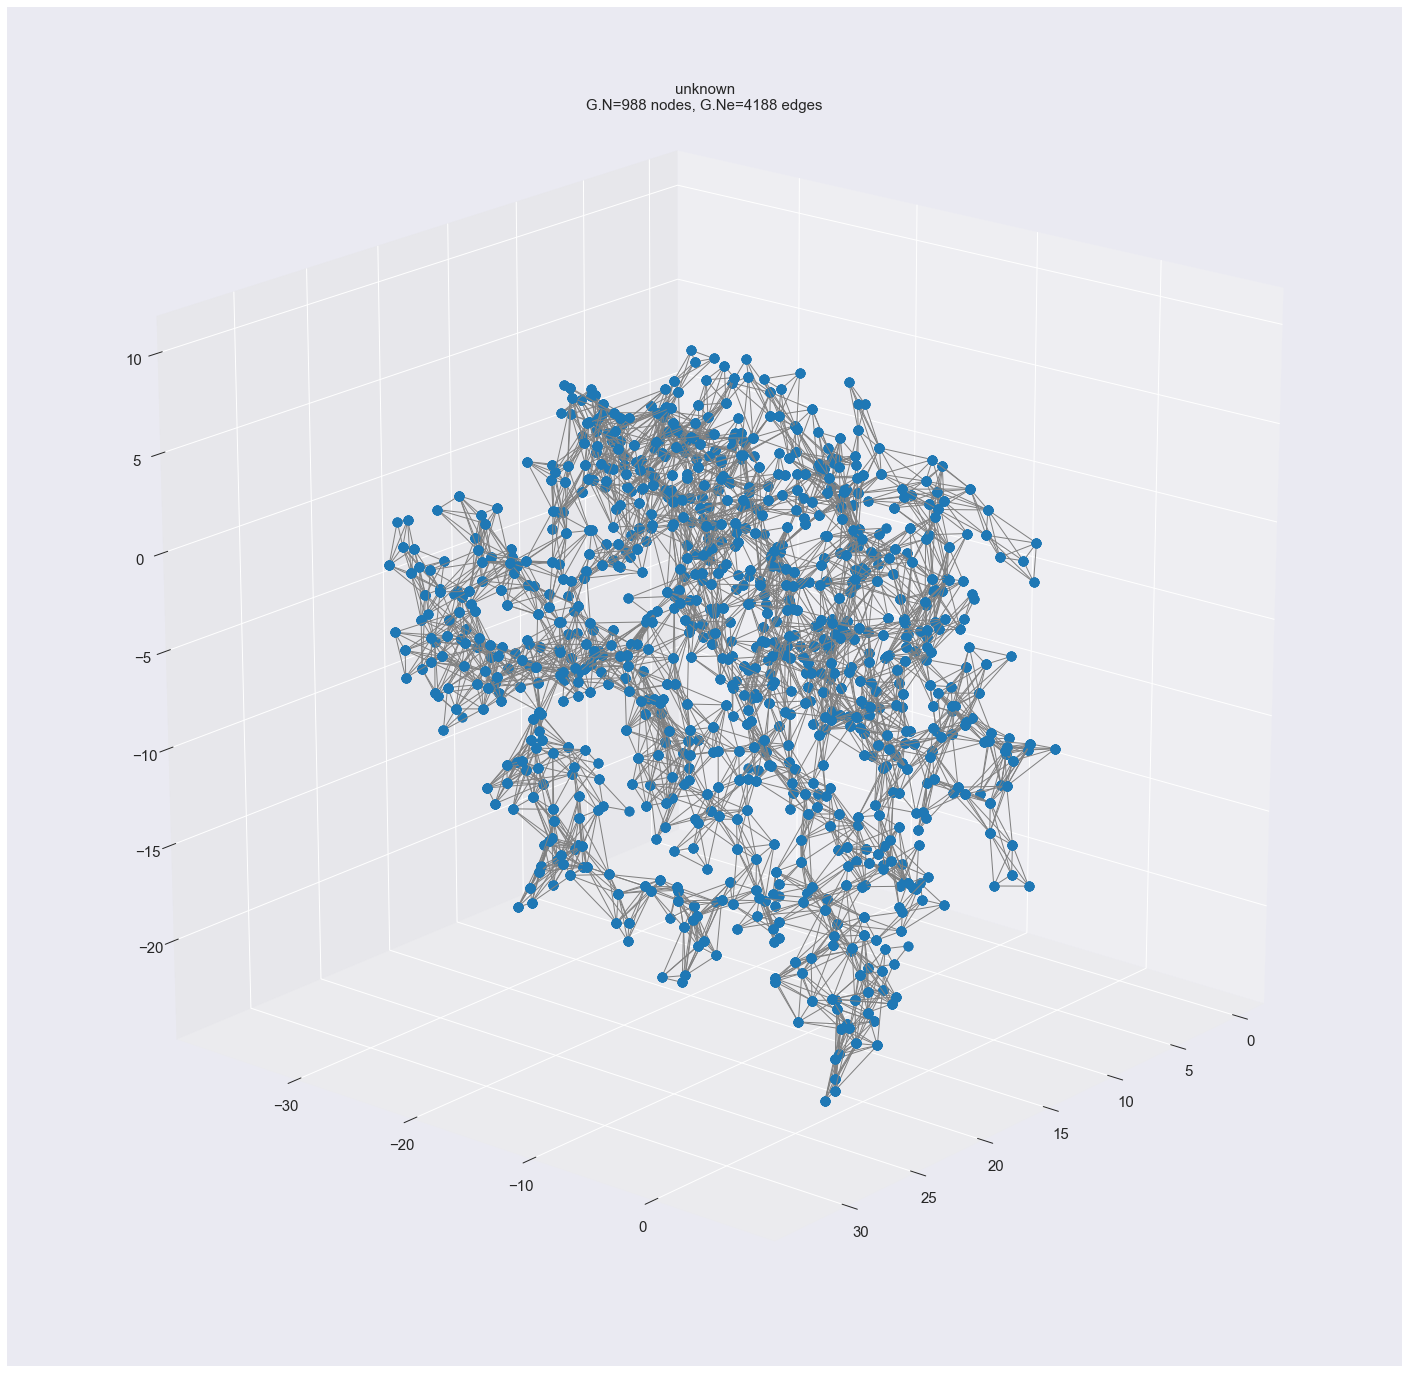

In [18]:
G = graphs.Graph(W=adjacency, coords=coords)
fig = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')
G.plot(ax=ax)
ax.view_init(20, 40)
plt.savefig('./example_graph.png')

https://plotly.com/python/v3/3d-network-graph/

In [19]:
x, y, z = coords[:,0], coords[:,1], coords[:,2]

trace1 = go.Scatter3d(x=x, y=y, z=z,
                      mode='markers',
                      marker=dict(
                          size=2.5,
                          color='darkblue',
                          opacity=0.9)
                     )

trace2 = go.Scatter3d(x=Xe, y=Ye, z=Ze,
                      mode='lines',
                      line=dict(color='rgb(125,125,125)', width=0.6),
                      hoverinfo='none'
                     )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title=target_names[0] + ' ' + adj_for_test[4][:-8],
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
         ),
         margin=dict(t=100),
         hovermode='closest')

data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

#py.iplot(fig, filename='Protein')

iplot(fig)

## Попарные расстояния

In [20]:
from scipy.spatial import distance_matrix

In [21]:
array_x = np.array(coords)
array_y = np.array(coords)

distance_mtrx = distance_matrix(array_x, array_y)

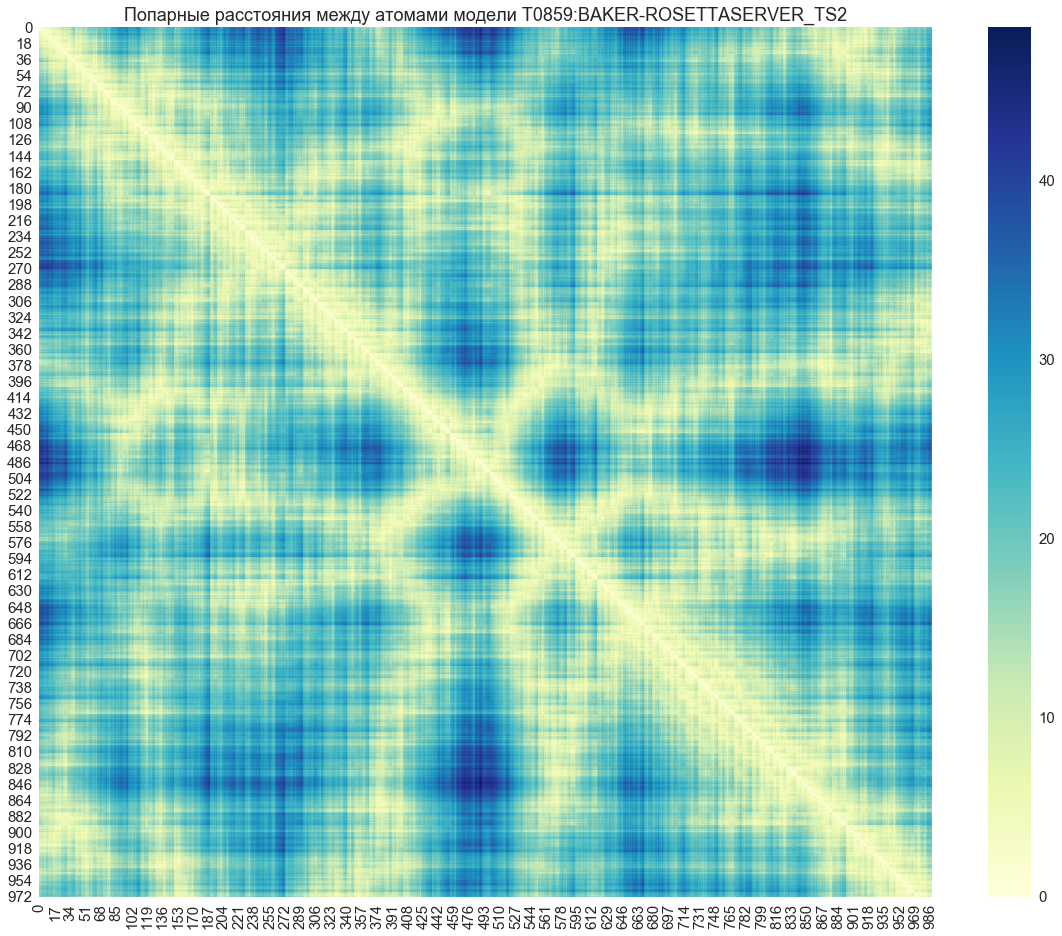

In [29]:
fig_dims = (20, 16)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_title('Попарные расстояния между атомами модели T0859:BAKER-ROSETTASERVER_TS2')

pairwise = sns.heatmap(distance_mtrx, cmap="YlGnBu")
pairwise.figure.savefig("pairwise.png")

In [23]:
distanceMax = ((2.0 + 2.0) * 0.6) ** 2
print('Максимальное расстояние между атомами, которые могут быть соединены {}'.format(distanceMax))

Максимальное расстояние между атомами, которые могут быть соединены 5.76


По рисунку видно, что могут иметь соединения атомы, обозначенные на рисунке самым светлым желтым. Т.е. матрица смежности будет сильно разреженной

## Сохранение в датасет

X – coordinates

A – adjacency matrices

y – cad-scores

#### y_train + y_test

In [2]:
cad_path = '../cad_results/'
targets = sorted(os.listdir(cad_path))[1:]

In [3]:
cad_scores_dict = dict()
#cad_scores = list()
for target in targets[:8]:
    filepath = cad_path + target
    with open(filepath) as fp:
        line = fp.readline()
        while line:
            list_temp = line.strip().split(' ')
            target = list_temp[0][24:-4]
            model = list_temp[1][24:]
            cad = float(list_temp[4])
            #cad_scores.append((target, model, cad))
            cad_scores_dict.update({(target, model): cad})
            line = fp.readline()

In [4]:
cad_scores_dict[(target, model)]

0.25839

**DATA format: {target_name}, {model_name}, {coordinates}, {adjacency_matrix}, {cad-score}**

In [7]:
DATA = list()
unwanted = {'.DS_Store', 'adjacency'}

for target in targets[:8]:
    target = target[:-11]
    adj_path = '../../data/CASP12/' + target + '/adjacency/'
    models_path = '../../data/CASP12/' + target
    
    # смотрим только те, к которым посчитаны матрицы смежности
    models = sorted(os.listdir(adj_path))
    #models.remove('.DS_Store')
    #models = sorted(os.listdir(models_path))
    models = [model for model in models if model not in unwanted]
    for model in tqdm(models):
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                list_temp = line.strip().split(' ')
                atom_number = int(list_temp[0][4:]) # atomXXX
                connections = list(map(int, list_temp[1:]))
                adjacency[atom_number][connections] = 1
                line = fp.readline()
        
        DATA.append((target, model[:-8], coords, adjacency, cad)) # model = <name>_adj.txt

100%|██████████| 25/25 [00:04<00:00,  6.11it/s]


In [8]:
len(DATA)

221

In [9]:
%%time
np.save('./data.npy', DATA)

CPU times: user 2.18 s, sys: 7.62 s, total: 9.8 s
Wall time: 18.7 s


Посмотреть сохранение в формат .hdf5